# Data Exploration - COVIDSenti Dataset

Comprehensive analysis of the dataset to understand:
- Total tweet counts
- News vs conversational distribution
- Sentiment distribution
- Example tweets by category

## Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_colwidth', 150)

## Load Dataset

In [6]:
# Load the parsed dataset (with syntactic parses)
df = pd.read_csv("../data/input_data/COVIDSenti/COVIDSenti_full_parsed.csv")

print(f"Total tweets: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head(3)

Total tweets: 90,000
Columns: ['tweet', 'label', 'conllu_parse']

First few rows:


,tweet,label,conllu_parse
0,Coronavirus | Human Coronavirus Types | CDC https://t.co/IxoxVRarIb,neu,# text = Coronavirus | Human Coronavirus Types | CDC https://t.co/IxoxVRarIb\n1\tCoronavirus\tCoronavirus\tPROPN\tNNP\t_\t2\tcompound\t_\t_\n2\t|\...
1,"@shehryar_taseer That‚Äôs üíØ true , \nCorona virus \nswine flue \nBird flu in December when whole Pk is busy in Marriage‚Ä¶ https://t.co/6JWBIymnyo",neu,"# text = @shehryar_taseer That‚Äôs üíØ true , \nCorona virus \nswine flue \nBird flu in December when whole Pk is busy in Marriage‚Ä¶ https://t.c..."
2,"TLDR: Not SARS, possibly new coronavirus. Difficult to confirm because patients identified later in infection when‚Ä¶ https://t.co/utKo0fxdgX",neg,"# text = TLDR: Not SARS, possibly new coronavirus.\n1\tTLDR\ttldr\tNOUN\tNN\t_\t0\tROOT\t_\t_\n2\t:\t:\tPUNCT\t:\t_\t1\tpunct\t_\t_\n3\tNot\tnot\t..."


## Basic Statistics

In [3]:
# Label distribution
print("Sentiment Distribution:")
print(df['label'].value_counts())
print(f"\nPercentages:")
print(df['label'].value_counts(normalize=True) * 100)

# Tweet length
df['tweet_length'] = df['tweet'].str.len()
df['word_count'] = df['tweet'].str.split().str.len()

print(f"\nTweet Statistics:")
print(f"  Average length: {df['tweet_length'].mean():.0f} characters")
print(f"  Average words: {df['word_count'].mean():.1f}")
print(f"  Min words: {df['word_count'].min()}")
print(f"  Max words: {df['word_count'].max()}")

Sentiment Distribution:
label
neu    67385
neg    16335
pos     6280
Name: count, dtype: int64

Percentages:
label
neu    74.872222
neg    18.150000
pos     6.977778
Name: proportion, dtype: float64

Tweet Statistics:
  Average length: 113 characters
  Average words: 15.0
  Min words: 1
  Max words: 32


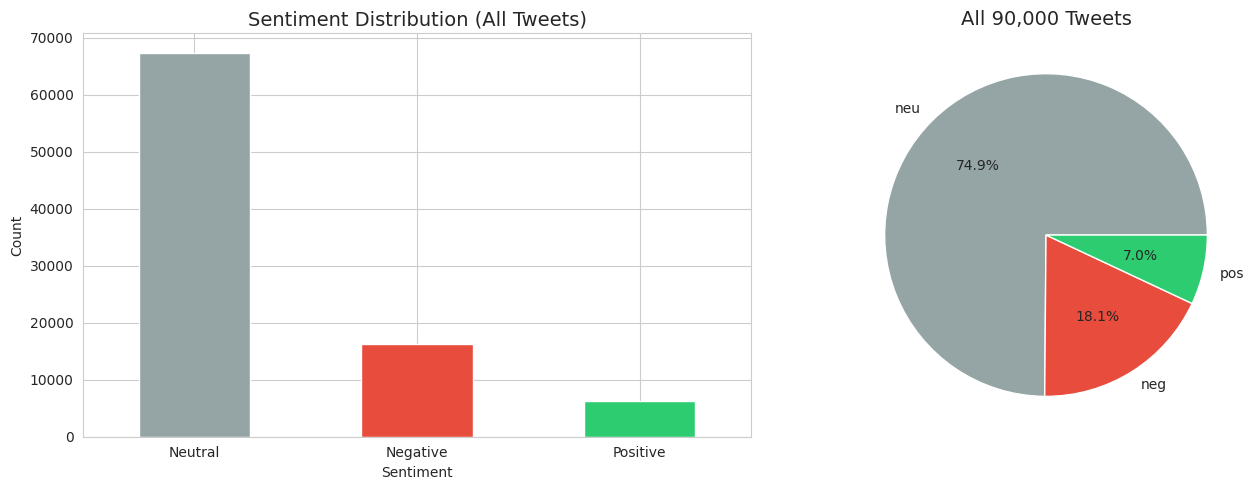

In [4]:
# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
df['label'].value_counts().plot(kind='bar', ax=ax1, color=['#95a5a6', '#e74c3c', '#2ecc71'])
ax1.set_title('Sentiment Distribution (All Tweets)', fontsize=14)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Neutral', 'Negative', 'Positive'], rotation=0)

# Pie chart
df['label'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                                colors=['#95a5a6', '#e74c3c', '#2ecc71'])
ax2.set_ylabel('')
ax2.set_title('All 90,000 Tweets', fontsize=14)

plt.tight_layout()
plt.show()

## News vs Conversational Filter

**Improved Multi-Signal Filter:**

**Strong news patterns (immediate filter):**
- Title | Format: "Coronavirus | CDC Updates"
- "via @username" (shared news)
- "RT @" (retweets)
- **NEW:** "Organization on Topic:" (e.g., "Wyoming Public Health on Coronavirus:")
- **NEW:** Colon + quote marks (quoted statements)

**Conversational signals (hierarchical):**
1. **First-person pronouns** (STRONG): "I", "my", "me", "we", "our"
   - Always conversational, even with URL
   - Example: "I have to admit #Covid19 sounds better... https://..."

2. **Question marks**: Usually conversational (people asking questions)

3. **Opinion + punctuation**: Opinion words + (? or !) 

4. **Second-person + opinion**: "you/your" + opinion words
   - Distinguishes "your hands" (directive) from "your opinion" (conversational)

5. **URLs without signals**: Likely news if no strong personal language

**Key improvement:** More nuanced than simple pattern matching - considers multiple signals and their combinations!

In [10]:
def is_news_like(tweet):
    tweet_lower = tweet.lower()

    strong_news_patterns = [
        r"^[A-Z][a-z]+ \| ",
        r"\bvia @",
        r"^RT @",
        r"^[A-Z][a-z\s]+ on [A-Z][a-z]+:",
        r':\s*["\u201c\u2018]',
    ]

    news_hashtags = [
        r"#smartnews",
        r"#breakingnews",
        r"#breaking",
        r"#news",
        r"#topstory",
        r"#headline",
        r"#update",
        r"#alert",
        r"#cnn",
        r"#fox",
        r"#bbc",
        r"#msnbc",
        r"#reuters",
    ]

    for pattern in strong_news_patterns:
        if re.search(pattern, tweet):
            return True

    for hashtag in news_hashtags:
        if hashtag in tweet_lower:
            return True

    first_person = [
        "i ",
        "my ",
        "me ",
        "i'm",
        "i've",
        "i'd",
        "i'll",
        "we ",
        "our ",
        "we're",
        "we've",
        "we'll",
    ]
    has_first_person = any(word in tweet_lower for word in first_person)

    has_question = "?" in tweet

    if has_first_person or has_question:
        return False

    if len(tweet.split()) < 5:
        return True

    headline_patterns = [
        r"^[A-Z][a-z\s]+ (man|woman|person|official|doctor|patient|resident)",
        r"\b(reports?|says?|confirms?|announces?|warns?|urges?)\s+(that|about)",
        r"^\w+\s+(is|was|has been|have been)\s+the\s+(first|second|latest)",
    ]

    for pattern in headline_patterns:
        if re.search(pattern, tweet):
            return True

    second_person = ["you ", "your ", "you're", "you've", "you'll"]
    has_second_person = any(word in tweet_lower for word in second_person)

    has_exclamation = "!" in tweet

    opinion_words = [
        "think",
        "feel",
        "believe",
        "hope",
        "wish",
        "hate",
        "love",
        "like",
        "dislike",
        "want",
        "need",
        "afraid",
        "worried",
        "glad",
        "happy",
        "sad",
        "angry",
        "confused",
        "admit",
        "crap",
        "damn",
        "wow",
        "omg",
        "wtf",
        "lol",
        "lmao",
    ]
    has_opinion = any(word in tweet_lower for word in opinion_words)

    has_url = bool(re.search(r"https?://", tweet))

    if has_opinion and has_exclamation:
        return False

    if has_second_person and has_opinion:
        return False

    if has_url:
        return True

    institutional = bool(
        re.search(
            r"\b(CDC|WHO|NIH|FDA|Health Department|Public Health)\b",
            tweet,
            re.IGNORECASE,
        )
    )
    if institutional:
        return True

    return True
    

df['is_news'] = df['tweet'].apply(is_news_like)

news_count = df['is_news'].sum()
conversational_count = (~df['is_news']).sum()

print(f"  News-like tweets: {news_count:,} ({news_count/len(df)*100:.1f}%)")
print(f"  Conversational tweets: {conversational_count:,} ({conversational_count/len(df)*100:.1f}%)")

  News-like tweets: 59,852 (66.5%)
  Conversational tweets: 30,148 (33.5%)


In [16]:
df[df['is_news']==True]["label"].value_counts() / len(df[df['is_news']==True]) * 100

label
neu    77.098510
neg    16.764686
pos     6.136804
Name: count, dtype: float64

In [20]:
df[(df['is_news']==True) &  (df['label']=="neg")] ["tweet"]

2         TLDR: Not SARS, possibly new coronavirus. Difficult to confirm because patients identified later in infection when‚Ä¶ https://t.co/utKo0fxdgX
16                                     @KariDebbink @Vineet321 The Frieman Scary Scale makes its debut. Wuhan Coronavirus scores 3 out of 10 N95 masks.
18       Crap, a quick blast search suggests the Wuhan coronavirus looks like a Bat SARS-like coronavirus with 89.12% identi‚Ä¶ https://t.co/GKa5j7KA9A
24                                                                   China releases genetic data on new coronavirus, now deadly https://t.co/DNJEioCRcm
31                          Brace yourself #America, this virus is nasty &amp; it‚Äôs a killer. #WHO #coronavirus #China #Japan https://t.co/E7y2YoleFx
                                                                              ...                                                                      
89913                                                           if you worked at world o

## Sentiment Distribution: News vs Conversational

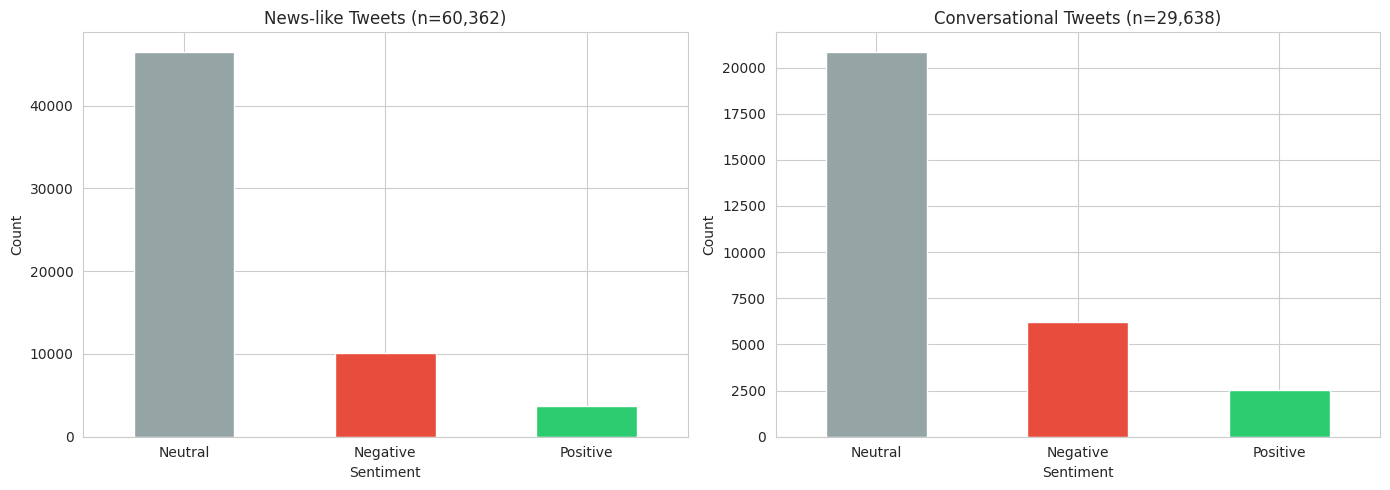


News-like sentiment:
label
neu    46520
neg    10112
pos     3730
Name: count, dtype: int64

Conversational sentiment:
label
neu    20865
neg     6223
pos     2550
Name: count, dtype: int64


In [ ]:
df_news = df[df['is_news']]
df_conv = df[~df['is_news']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# News tweets
df_news['label'].value_counts().plot(kind='bar', ax=ax1, color=['#95a5a6', '#e74c3c', '#2ecc71'])
ax1.set_title(f'News-like Tweets (n={len(df_news):,})', fontsize=12)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Neutral', 'Negative', 'Positive'], rotation=0)

# Conversational tweets
label_counts = df_conv['label'].value_counts()
label_names = {'neu': 'Neutral', 'neg': 'Negative', 'pos': 'Positive'}
label_colors = {'neu': '#95a5a6', 'neg': '#e74c3c', 'pos': '#2ecc71'}
display_labels = [label_names.get(lbl, lbl) for lbl in label_counts.index]
colors = [label_colors.get(lbl, '#3498db') for lbl in label_counts.index]

label_counts.plot(kind='bar', ax=ax2, color=colors)
ax2.set_title(f'Conversational Tweets (n={len(df_conv):,})', fontsize=12)
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Count')
ax2.set_xticklabels(display_labels, rotation=0)

plt.tight_layout()
plt.show()

print("\nNews-like sentiment:")
print(df_news['label'].value_counts())
print("\nConversational sentiment:")
print(df_conv['label'].value_counts())

## Example Tweets - News-like

In [8]:
print("="*100)
print("NEWS-LIKE TWEETS (filtered out for ABSA)")
print("="*100)

# Show random news tweets
news_sample = df_news.sample(n=10, random_state=42)
for i, (idx, row) in enumerate(news_sample.iterrows(), 1):
    print(f"\n{i}. [{row['label'].upper()}] {row['tweet']}")

NEWS-LIKE TWEETS (filtered out for ABSA)

1. [NEG] @FxPesaKenya #Coronavirus effects on commodity-based African economies

~ Angola‚Äôs Sonangol forced to sell one #Oil‚Ä¶ https://t.co/M7a6d9NMph

2. [NEG] @CBSNews Hurry with Iran's help It is too late to control the corona virus tomorrow

3. [NEG] @seanhannity The Dems saying Trump is to incompetent to respond to the coronavirus 1. Couldn‚Äôt count votes in Iowa‚Ä¶ https://t.co/YnfyYzgLQK

4. [NEU] HIMSS Update on the Coronavirus - HIMSS20 https://t.co/hZONcnByjT #HIMSS20

5. [NEG] U.S. is now way behind in testing, and is exporting coronavirus.

Watch the numbers.

Watch the reporting.

Watch w‚Ä¶ https://t.co/ibhotgljqJ

6. [NEU] Live updates: Cruise ship held off California coast; coronavirus turmoil grows as U.S. death toll mounts  https://t.co/5V7kgeRupt

7. [NEU] #BreakingNews 6 more cases of #coronavirus in San Francisco, CA raising its total to 8.

8. [NEU] President Donald Trump Donates His $100,000 Salary To Combat Coronavir

## Example Tweets - Conversational

In [9]:
print("="*100)
print("CONVERSATIONAL TWEETS (kept for ABSA)")
print("="*100)

# Show random conversational tweets
conv_sample = df_conv.sample(n=min(20, len(df_conv)), random_state=42)
for i, (idx, row) in enumerate(conv_sample.iterrows(), 1):
    print(f"\n{i}. [{row['label'].upper()}] {row['tweet']}")

CONVERSATIONAL TWEETS (kept for ABSA)

1. [NEU] @marcorubio the media should be quiet about the threat of coronavirus, the same way the press and government was qu‚Ä¶ https://t.co/HNIioxIdC5

2. [NEU] @OmzloElec Don't be worried . There are no coronavirus in our factory .. Our factory is far away from CBD and produ‚Ä¶ https://t.co/0fnLvmMhqo

3. [NEG] How to keep your relationship intact if you're forced to work from home because of the coronavirus outbreak‚Ä¶ https://t.co/8yFG6ZyCvh

4. [POS] Hi, I'll be consistently sharing the latest Coronavirus news! Please follow me and share!
I believe it was not the‚Ä¶ https://t.co/5yCauo5aKx

5. [NEU] $APDN OVERSOLD! #CORONAVIRUS GEM. LOADING!!!üí∏ $vyst $ammx $cnhc $mcgi $dnad $wwio $anwwq $shldq $shmp $fuszd $fnma‚Ä¶ https://t.co/Gq2R9xP7iV

6. [NEU] @realDonaldTrump https://t.co/A8HzmoBNli ‚Ä∫ coronavirus
Coronavirus Update (Live): 114,268 Cases and 4,009 Deaths fr‚Ä¶ https://t.co/bnFRvSlPPe

7. [NEU] @BreitbartNews @GOPLeader What, exactly

## Conversational Tweets by Sentiment

In [10]:
# Show conversational examples grouped by sentiment
for sentiment in ['neg', 'neu', 'pos']:
    sentiment_tweets = df_conv[df_conv['label'] == sentiment]
    if len(sentiment_tweets) == 0:
        continue
    
    sentiment_name = {'neg': 'NEGATIVE', 'neu': 'NEUTRAL', 'pos': 'POSITIVE'}[sentiment]
    print(f"\n{'='*100}")
    print(f"{sentiment_name} Conversational Tweets (n={len(sentiment_tweets):,})")
    print(f"{'='*100}")
    
    # Show up to 10 examples
    sample = sentiment_tweets.sample(n=min(10, len(sentiment_tweets)), random_state=42)
    for i, (idx, row) in enumerate(sample.iterrows(), 1):
        print(f"\n{i}. {row['tweet']}")


NEGATIVE Conversational Tweets (n=6,223)

1. Chinese female nurses are being shaved all their hairs off, crying. #coronavirus  We support the Gender Equality or‚Ä¶ https://t.co/QQxqoHJwx4

2. @brianbeutler My concern, I heard talk of using VA health system to handle coronavirus. This is a really bad idea.‚Ä¶ https://t.co/t6NXowtno8

3. @SpeakerPelosi The Coronavirus is deadly. How will you protect America from an outbreak if you can‚Äôt identify travelers?

4. Oh shit I just sneezed. Must have coronavirus

5. All politics aside. 

When are people going to start asking serious questions about #coronavirus? 

Wuhan? (researc‚Ä¶ https://t.co/IcY0wiQuP0

6. We need to be cautious, when it comes to safety  and awareness of the public. The Coronavirus deadly epidemic is se‚Ä¶ https://t.co/kZTYunU2QA

7. Say coronavirus or any other event causes mass quarantines, how are workers protected by labour laws?
Some can affo‚Ä¶ https://t.co/o64P4RG1H3

8. online classes are so annoying I have like 

## Tweet Length Analysis

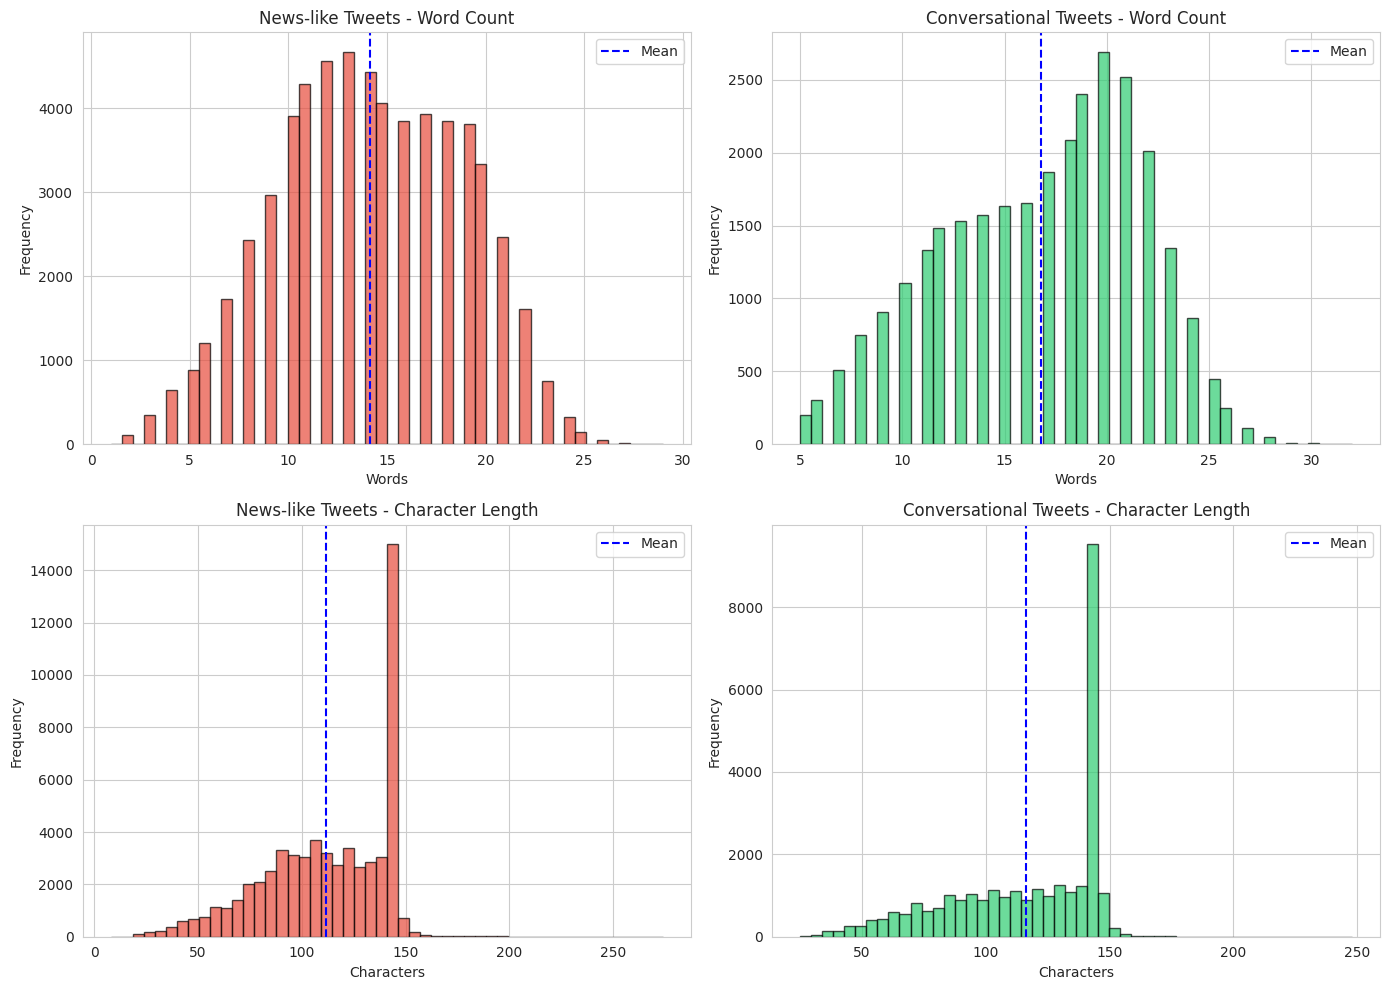

Average word count:
  News-like: 14.1
  Conversational: 16.8


In [11]:
# Compare tweet lengths
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Word count - News
axes[0,0].hist(df_news['word_count'], bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[0,0].axvline(df_news['word_count'].mean(), color='blue', linestyle='--', label='Mean')
axes[0,0].set_title('News-like Tweets - Word Count')
axes[0,0].set_xlabel('Words')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Word count - Conversational
axes[0,1].hist(df_conv['word_count'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0,1].axvline(df_conv['word_count'].mean(), color='blue', linestyle='--', label='Mean')
axes[0,1].set_title('Conversational Tweets - Word Count')
axes[0,1].set_xlabel('Words')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Character length - News
axes[1,0].hist(df_news['tweet_length'], bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[1,0].axvline(df_news['tweet_length'].mean(), color='blue', linestyle='--', label='Mean')
axes[1,0].set_title('News-like Tweets - Character Length')
axes[1,0].set_xlabel('Characters')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Character length - Conversational
axes[1,1].hist(df_conv['tweet_length'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[1,1].axvline(df_conv['tweet_length'].mean(), color='blue', linestyle='--', label='Mean')
axes[1,1].set_title('Conversational Tweets - Character Length')
axes[1,1].set_xlabel('Characters')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("Average word count:")
print(f"  News-like: {df_news['word_count'].mean():.1f}")
print(f"  Conversational: {df_conv['word_count'].mean():.1f}")

## Export Conversational Subset

In [ ]:
output_path = "data/COVIDSenti/COVIDSenti_conversational_only.csv"
df_conv.to_csv(output_path, index=False)

print(f"Saved {len(df_conv):,} conversational tweets to:")
print(f"  {output_path}")

Saved 29,638 conversational tweets to:
  data/COVIDSenti/COVIDSenti_conversational_only.csv

This file is ready for teacher annotation!
